<a id="top"/>

## Overview

This notebook performs sentiment analysis on twitter dataset obtained from Kaggle

Link to dataset: https://www.kaggle.com/c/twitter-sentiment-analysis2/data

- <a href="#section1"> Section 1: Exploring the training dataset </a>
- <a href="#section2"> Section 2: Test data </a>
- <a href="#section3"> Section 3: Pre-Processing data for Sentiment Analysis</a>
- <a href="#section4"> Section 4: Training and Evaluation </a>
- <a href="#section5"> Section 5: Metrics, Measurements and Conclusion </a>


<a id="section1"/>

## Section1: Exploring the training dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
import re
import string

from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import random

In [2]:
train_file = 'data/train.csv'
test_file = 'data/test.csv'

#Explore the training dataset
#Note: For some reason, if you dont specify the encoding as latin-1, the interpreter will throw an UTF-8 encoding error
data = pd.read_csv(train_file, error_bad_lines=False, encoding='latin-1')
data.columns = ['id', 'sentiment', 'text']
data.head(2)

,id,sentiment,text
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...


In [3]:
#Id information is not useful. So let's remove it
#axis=1 indicates columns
data = data.drop(labels=['id'], axis=1)
data.head(10)

,sentiment,text
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...
5,0,or i just worry too much?
6,1,Juuuuuuuuuuuuuuuuussssst Chillin!!
7,0,Sunny Again Work Tomorrow :-| ...
8,1,handed in my uniform today . i miss you ...
9,1,hmmmm.... i wonder how she my number @-)


### Observations:
1. Data has a mix of alphabets, numbers and symbols
2. Mix of words with uppercase and lowercase letters
3. We need to normalize the words to their base word. Leaving capitalizaed words in the middle of the tweet can be
   experimented with as they may hold different feature space like name of the person, country, etc.. 
4. No particular order of sentiment and tweets. If data is not randomly distributed then it can introduce bias to a learning model
5. Need to split and shuffle the data to reduce variance (makes sure the model can generalize better on the data) 
   and does not lead to overfitting 
6. Need to get an idea of the distribution of data

In [4]:
# calculate the number of positive and negative tweets
positives = data['sentiment'][data.sentiment == 1]
negatives = data['sentiment'][data.sentiment == 0]

print('Number of postive tweets {}' .format(len(positives)))
print('Number of negative tweets {}' .format(len(negatives)))
print('Total Length of the data is: {}' .format(data.shape[0]))

Number of postive tweets 56457
Number of negative tweets 43532
Total Length of the data is: 99989


### More observations
7. From the result, looks like an even distribution of positive and negative sentiments
8. Are there any duplicates in the data? Get the unique counts to identify this
9. How many average number of words are there in a tweet? Do a word count
10. What are the most common words present in the dataset?

In [5]:
data.groupby('sentiment').describe()

text                                                            \
           count unique                                                top   
sentiment                                                                    
0          43532  43532  @ChuckNerd well, if I don't have to buy anythi...   
1          56457  56457  @aimeeleelucas the meeting was good! he wants ...   

                
          freq  
sentiment       
0            1  
1            1

Seems like there are no duplicates

In [6]:
# Function to calculate the number of words in a sentence.
# Using the delimiter to be a space
def word_count(tweet):
    return len(tweet.split())

data['word_count'] = data['text'].apply(word_count)
data.head(5)

,sentiment,text,word_count
0,0,is so sad for my APL frie...,7
1,0,I missed the New Moon trail...,6
2,1,omg its already 7:30 :O,5
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,25
4,0,i think mi bf is cheating on me!!! ...,9


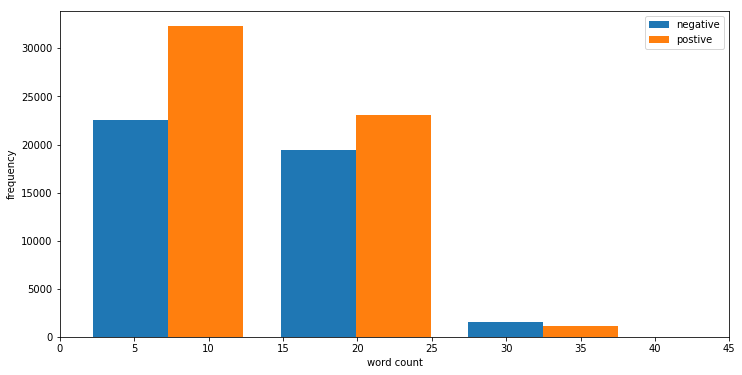

In [7]:
# Plot a histogram of the word counts

x = data['word_count'][data.sentiment == 0]
y = data['word_count'][data.sentiment == 1]
plt.figure(figsize=(12,6))
plt.xlabel('word count')
plt.ylabel('frequency')
graph = plt.hist([x,y], label=['negative', 'postive'])
plt.xlim(0,45)
plt.legend(loc='upper right')

### More observations

- From the histogram, it seems like most data seems to be less than 25 words. This is mostly because the tweet is less than 280 characters and so this data is good representative for twitter data
- Majority of them in the range of 5 to 10. 
- As the word count increases, the tweets tend to be negative
- There are more postive sentences/tweets which are 10 words an less


In [8]:
# Collect all the words in the training dataset
all_words = []
for line in list(data['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())

Counter(all_words).most_common(15)

[('i', 48880),
 ('the', 29629),
 ('to', 29177),
 ('you', 23456),
 ('a', 21908),
 ('and', 15826),
 ('it', 14154),
 ('my', 13598),
 ('for', 12378),
 ('is', 11618),
 ('in', 11497),
 ('of', 10519),
 ('that', 10051),
 ('have', 9794),
 ('on', 9228)]

- This shows the top 15 common words in the training dataset
- From the list, the stop words like **the**, **to** etc.. are very highly used. They are generally used in both positive and negative expressions and hence do not add any information that can be incorporated into the model. So these words can be removed from the data set

###  Frequency Distribution
Frequency distribution = frequency of each vocabulary item in the text

It is a distribution because it tells us how the total number of word tokens in the text are distributed across the vocabulary items. 

Reference: https://www.nltk.org/book/ch01.html

<FreqDist with 165473 samples and 1330178 outcomes>


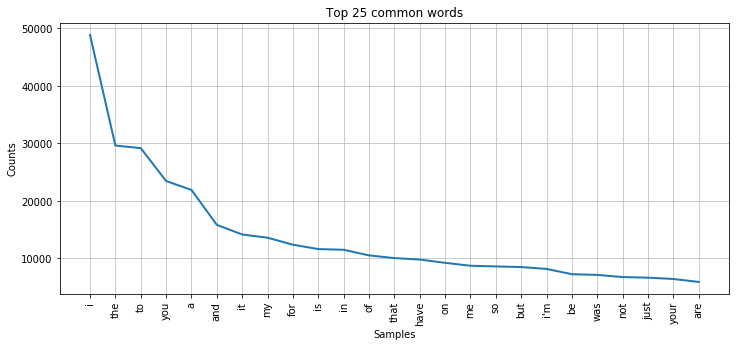

In [9]:
# plot word frequency distribution of top common words
plt.figure(figsize=(12,5))
plt.title("Top 25 common words")
fd = nltk.FreqDist(all_words)
print(fd)
fd.most_common(25)
fd.plot(25, cumulative=False)

### Log-Log Plot

Both dimensions are in logarithmic scale.

Reasons to construct a log log plot:

1. To respond to skewness towards large values; i.e., cases in which one or a few points are much larger than the bulk of the data.
2. To show percent change or multiplicative factors.

Text(0.5,1,"Log-Log Plot of words' frequency")

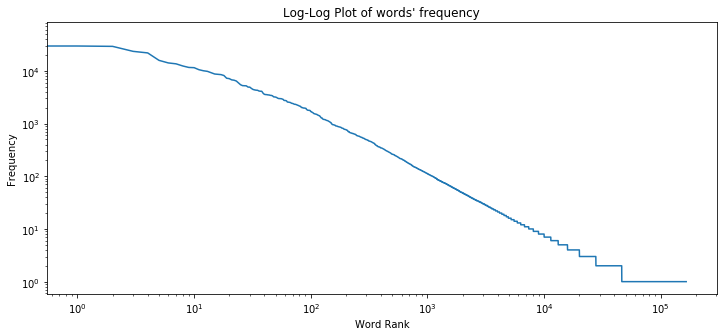

In [10]:
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts)
plt.xlabel("Word Rank")
plt.ylabel("Frequency")
plt.title("Log-Log Plot of words' frequency")

The log-log plot for the words frequency and word rank. It is for the entire training dataset. 

- Seems like the frequency drops as the rank decreases (Note: As far as word rank goes, higher the number lower the rank)
- Need to check if this still holds true after removing the stop words

<a href="#top"> Back to Top </a>

<a id="section2"/>

### Section 2: Test Data

In [11]:
test_data=pd.read_csv(test_file, error_bad_lines=False, encoding='latin-1')
test_data.head(2)

,ItemID,SentimentText
0,1,is so sad for my APL frie...
1,2,I missed the New Moon trail...


In [12]:
#Id information is not useful
test_data=test_data.drop(labels=['ItemID'], axis=1)
test_data.head(5)

,SentimentText
0,is so sad for my APL frie...
1,I missed the New Moon trail...
2,omg its already 7:30 :O
3,.. Omgaga. Im sooo im gunna CRy. I'...
4,i think mi bf is cheating on me!!! ...


<a href="#top"> Back to Top </a>

<a id="section3"/>

### Section 3: Pre-Processing data for Sentiment Analysis

Text pre-processing is an important step in a Natural Language Processing (NLP) task because it helps remove any unnecessary characteristics in the data which would make the final trained model a poor generalizer

What is involved in the pre-processing?

- Removing unwanted characters like punctuations, emojis, etc...
- Properly formatting the text to remove extra spaces or any other information in that text
- Removing stop words, common words that do not add any useful information 
- Need to make sure that the information we pass the model is in the format that a machine can understand (as binary/digits)
- Pre-Processing is done on the training data to facilitate the model's learning 

After pre-processing step, data should be fed to an appropriate machine learning algorithm to extract valuable information to do classification on new (unseen) data 

#### Pre-processing Step 1

Clean the tweet data by removing any hyperlinks and special characters

In [13]:
#Function to clean the tweets
def processText(text):
    #Convert to lowercase
    text = text.lower()    
    #Remove hyperlinks
    text = re.sub(r'http?:\/\/.*\/\w*', '', text)
    #Remove symbols, punctuations and replace with a space
    text = re.sub(r'[@!,;:)()_|]+', ' ', text)
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+', ' ', text)
    #Remove single space remaining at the front of the text
    text = text.lstrip(' ')
    return text

In [14]:
data['preprocessed'] = data['text'].apply(processText)
data.head(10)

,sentiment,text,word_count,preprocessed
0,0,is so sad for my APL frie...,7,is so sad for my apl friend.............
1,0,I missed the New Moon trail...,6,i missed the new moon trailer...
2,1,omg its already 7:30 :O,5,omg its already 7 30 o
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,25,.. omgaga. im sooo im gunna cry. i've been at ...
4,0,i think mi bf is cheating on me!!! ...,9,i think mi bf is cheating on me t t
5,0,or i just worry too much?,6,or i just worry too much?
6,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,2,juuuuuuuuuuuuuuuuussssst chillin
7,0,Sunny Again Work Tomorrow :-| ...,7,sunny again work tomorrow - tv tonight
8,1,handed in my uniform today . i miss you ...,10,handed in my uniform today . i miss you already
9,1,hmmmm.... i wonder how she my number @-),8,hmmmm.... i wonder how she my number -


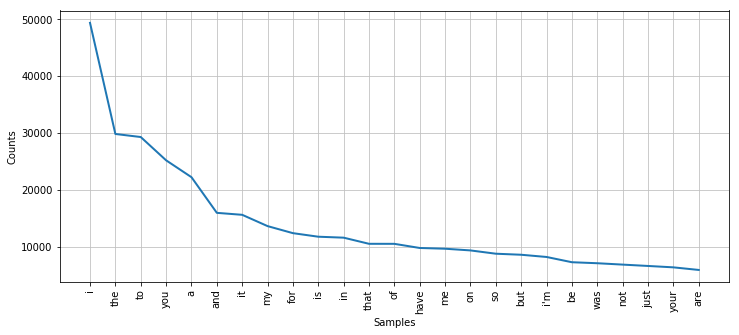

Text(0,0.5,'Frequency')

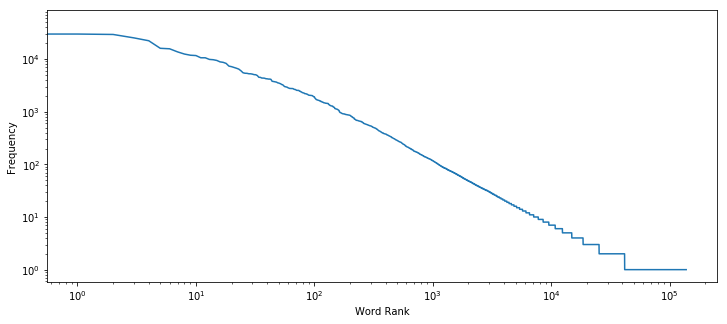

In [15]:
#Most common words in twitter dataset
all_words = []
for line in list(data['preprocessed']):
    words = line.split()
    for word in words:
        all_words.append(word)

# plot word frequency distribution of top 25
plt.figure(figsize=(12,5))
fd = nltk.FreqDist(all_words)
fd.plot(25, cumulative=False)
  
word_counts = sorted(Counter(all_words).values(), reverse=True)

#log-log of all words
plt.figure(figsize=(12,5))
plt.loglog(word_counts)
plt.xlabel("Word Rank")
plt.ylabel("Frequency")


In [16]:
#drop duplicates
data.shape

(99989, 4)

In [17]:
data = data.drop_duplicates('text')
data.shape

(99989, 4)

#### Preprocessing Step2: Tokenize without the stop words

The training data has not been transformed/preprocessed into a much cleaner set for feature extraction. 
There are some words in the dataset that are common in natural human language but used in all sentiment expressions that would be better off without them since they bring no useful features to our modele
These words are called "Stop words" in NLP and NLTK library comes with a dataset containing a long list of stop words that can be accessed and used to filter out of our dataset. The stop_words list can be customized depending on the dataset that we are working on - say legal documents or annual reports, then we need to add jargons corresponding to that dataset.


In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swsundar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
# print out the stop words
stop_words = stopwords.words('english')
print(','.join(stop_words))

len(stop_words)

i,me,my,myself,we,our,ours,ourselves,you,you're,you've,you'll,you'd,your,yours,yourself,yourselves,he,him,his,himself,she,she's,her,hers,herself,it,it's,its,itself,they,them,their,theirs,themselves,what,which,who,whom,this,that,that'll,these,those,am,is,are,was,were,be,been,being,have,has,had,having,do,does,did,doing,a,an,the,and,but,if,or,because,as,until,while,of,at,by,for,with,about,against,between,into,through,during,before,after,above,below,to,from,up,down,in,out,on,off,over,under,again,further,then,once,here,there,when,where,why,how,all,any,both,each,few,more,most,other,some,such,no,nor,not,only,own,same,so,than,too,very,s,t,can,will,just,don,don't,should,should've,now,d,ll,m,o,re,ve,y,ain,aren,aren't,couldn,couldn't,didn,didn't,doesn,doesn't,hadn,hadn't,hasn,hasn't,haven,haven't,isn,isn't,ma,mightn,mightn't,mustn,mustn't,needn,needn't,shan,shan't,shouldn,shouldn't,wasn,wasn't,weren,weren't,won,won't,wouldn,wouldn't


179

- There seems to be a total of 179 stop words in the nltk corpus
- Next step: Remove the stop words, split all the sentences in the dataset to get individual words (called tokens) which is basically a list of words contained in the newly preprocessed set

In [20]:
def text_process(raw_text):
    '''
    Take a string of text, then perform the following:
    1. Remove all punctuation
    2. Remove all stop words
    3. Returns a list of processed text
    '''
    nopunct = [char for char in list(raw_text) if char not in string.punctuation]
    nopunct = ''.join(nopunct)
    return [word for word in nopunct.lower().split()
               if word.lower() not in stop_words]

In [21]:
# tokenize the data and create a column for tokens
data_copy = data.copy()
data_copy['tokens'] = data['preprocessed'].apply(text_process)
data_copy.head()

,sentiment,text,word_count,preprocessed,tokens
0,0,is so sad for my APL frie...,7,is so sad for my apl friend.............,"[sad, apl, friend]"
1,0,I missed the New Moon trail...,6,i missed the new moon trailer...,"[missed, new, moon, trailer]"
2,1,omg its already 7:30 :O,5,omg its already 7 30 o,"[omg, already, 7, 30]"
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,25,.. omgaga. im sooo im gunna cry. i've been at ...,"[omgaga, im, sooo, im, gunna, cry, ive, dentis..."
4,0,i think mi bf is cheating on me!!! ...,9,i think mi bf is cheating on me t t,"[think, mi, bf, cheating]"


- Additional normalization techniques like stemming and lemmatization can be done. These may not be useful for twitter data because they are short my design and stemming and lemmatization shorten words to their base words

Resources:
- http://www.nltk.org/howto/stem.html
- http://www.nltk.org/api/nltk.stem.html?highlight=lemmatizer#nltk.stem.wordnet.WordNetLemmatizer

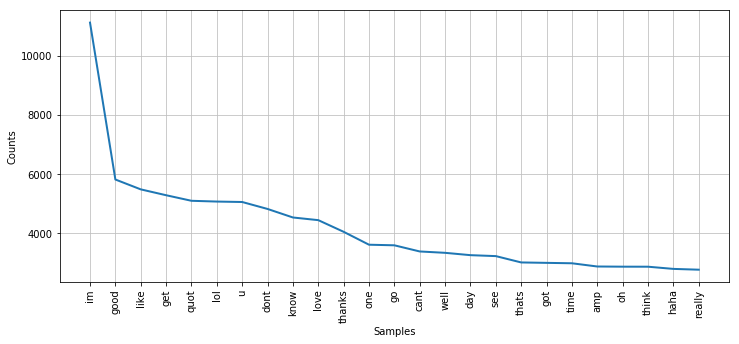

Text(0,0.5,'frequency')

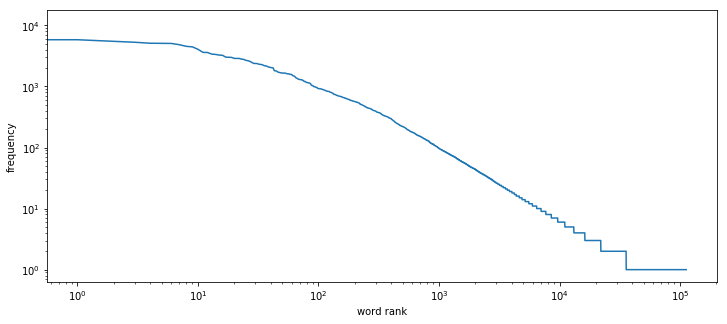

In [22]:
# now lets understand and explore the tokens further
all_tokens = []
for tokens in data_copy['tokens']:
    words = [w for w in tokens]
    for word in words:
        all_tokens.append(word)

#plot the word frequency distribution
plt.figure(figsize=(12,5))
fd = nltk.FreqDist(all_tokens)
fd.plot(25, cumulative=False)

word_counts = sorted(Counter(all_tokens).values(), reverse=True)

#plot the log log graph for all tokens
plt.figure(figsize=(12,5))
plt.loglog(word_counts)
plt.xlabel("word rank")
plt.ylabel("frequency")



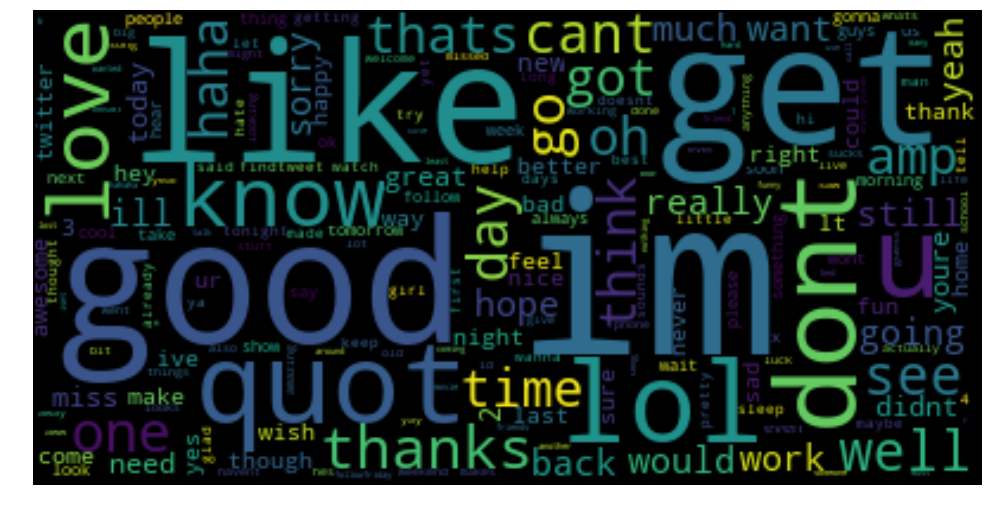

In [24]:
#building the word cloud
word_freq = Counter(all_tokens)

# to install the wordcloud run the command:
# conda install -c conda-forge wordcloud
word_cloud = WordCloud(normalize_plurals=True).generate_from_frequencies(word_freq)

plt.figure(figsize=(17,14))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Preprocessing Step 4: Feature Extraction

Now convert each set of tokens into a vector that a ML model can work on

##### Bag of Words

Bag of Words model is a 3 step process:

1. Count how many times a word occurs in each tweet (Term Frequency)
2. Weigh the counts such that the frequent words get lower weights (Inverse Document Frequency)
3. Normalize the vector to unit length to abstract from the original text (L2 Norm)

Notes:

- We will use the CountVectorizer from scikit-learn that converts the text documents into a matrix of count vector.
- Imagine it as a 2D matrix, where 1D is a vocabulary contained in the tweets and the other dimension is one column per tweet
- Since there are so many tweets and few words, then we can expect many zero counts for every word in the data. So we will use Sparse Matrix represntation

##### Resources:
1. Bag of Words: 
2. python scikit-learn:
3. Sparse Matrix:
4. Term Frequency:
5. Inverse Document Frequency:
6. To install sklearn:
       conda install scikit-learn 


In [23]:
#vectorize
bow_transformer = CountVectorizer(analyzer=text_process).fit(data_copy['text'])

#total number of words in the vocabulary?
print(len(bow_transformer.vocabulary_))


119942


In [24]:
# vector representation
sample_tweet = data_copy['text'][2153]
print(sample_tweet)
print('\n')

bow_sample = bow_transformer.transform([sample_tweet])
print(bow_sample)
print('\n')

 got first period for summer school.


  (0, 65040)	1
  (0, 68210)	1
  (0, 92400)	1
  (0, 101536)	1
  (0, 107055)	1




In [25]:
# transform the entire DataFrame of tweets
tweets_bow = bow_transformer.transform(data_copy['text'])

# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', tweets_bow.shape)
print('Amount of Non-Zero occurences: ', tweets_bow.nnz)


Shape of Sparse Matrix:  (99989, 119942)
Amount of Non-Zero occurences:  776038


#### Term Frequency and Inverse Document Frequency

In order to get a sparse matrix of TF/IDF values,
1. Tokenize
2. Count tokens
3. Transform counts to TF/IDF values


Count Vectorizer   = does 1 and 2
TF-IDF Transformer = starts at step2, and does step 3
TF-IDF Vectorizer  = CountVectorizer + TF-IDF Transformer

##### What is TF-IDF?

TF-IDF stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus.

The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.
One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

##### What is TF?

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

##### What is IDF?

IDF: Inverse Document Frequency, measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

##### Example

Consider a document with 1000 words and the a word "trump" appears 5 times in it.

The term-frequency for the word "trump" is (5 / 1000 = 0.005).

Now if we assume that there are about a million documents in the corpus and the word "trump" appears in about 1000 of those documents, 

Then the Inverse-Document-Frequency (idf) is log_e(1000000 / 1000) = log_e(1000) = 3

Thus, the Tf-idf weight is the product of these quantities: 3 * 0.005 = 0.015


In [26]:
tfidf_transformer = TfidfTransformer().fit(tweets_bow)
tfidf_sample = tfidf_transformer.transform(bow_sample)
print(tfidf_sample)

  (0, 107055)	0.43528691790640356
  (0, 101536)	0.4169391412338994
  (0, 92400)	0.6187710129794788
  (0, 68210)	0.3102531091146477
  (0, 65040)	0.3969288266021083


In [27]:
# Print the IDF
tfidf_transformer.idf_[bow_transformer.vocabulary_['good']]

3.889292232782331

In [28]:
# To transform the entire bag of words corpus

tweets_tfidf = tfidf_transformer.transform(tweets_bow)
print(tweets_tfidf.shape)

(99989, 119942)


- We can now pass it through a ML classification algorithm
- This ends the text pre-processing stage of our ML workflow

<a href="#top"> Back to Top </a>

<a id="section4"/>

## Section 4: Model Training and Evaluation

The task at hand is classification. Given a tweet, we need to classify it into either a positive or negative tweet based on the features we have extracted

#### Naive Bayes Classifier

Naive Bayes (NB) classifier which is based on the Bayes Theorem. In a nutshell, the NB classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. So for example, a fruit may be considered to be an apple if it is red, round, and about 3″ in diameter. A Naive Bayes classifier considers each of these “features” (red, round, 3” in diameter) to contribute independently to the probability that the fruit is an apple, regardless of any correlations between features. Features, however, aren’t always independent which is often seen as a shortcoming of the Naive Bayes algorithm and this is why it’s labeled “naive”. However it is relatively simple to understand, build and train and mostly very fast all which makes it a good candidate for sentiment classification.

- Bayes theorem provides a way of calculating posterior probability P(c|x) from P(c), P(x) and P(x|c). 

Look at the equation below:


#### Pipeline

- Create Pipeline to manage the above preprocessing steps in one step
- SciKit Learn provides a pipeline capability that lets you define a pipeline workflow which will take all the above steps and even a classifier and grid search parameters.
- Pipelines make code more readable and makes it easy to swap out pipeline pieces, which can include other ML algorithims and try different configurations
- Pipelines also allow for Cross Validation on to the model workflow.
- Pipelines also help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

#### Cross Validation:

- The recommended method for training a good model is to first cross-validate using a portion of the training set itself to check if you have used a model with too much capacity (i.e. if the model is overfitting the data).
- To cross-validate and select the best parameter configuration at the same time, we use GridSearchCV.
  This allows us to easily test out different hyperparameter configurations using for example the KFold strategy to split the model into random parts to find out if it's generalizing well or if it's overfitting.
- GridSearchCV allows you do define a ParameterGrid with hyperparameter configuration values to iterate over. All combinations are tested and scored and the best model returned.

For our case, there are 4 + 2 + 2 parameter combinations to test and 10 kfold validations, so the model will be trained and tested on the validation set 8 x 10 = 80 times.
    
#### Resources:

- Scikit learn Pipeline: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
- https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines
- GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- RandomSearch:
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [29]:
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(data['preprocessed'], data['sentiment'], test_size=0.2)

x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=0.5)

# create pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words='english',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-2, 1e-3),
             }

# do 10-fold cross validation for each of the 8 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(x_train,y_train)

# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  4.2min finished



Best Model: 0.713418 using {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}


Mean: 0.696066 Stdev:(0.007619) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.712505 Stdev:(0.006192) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.694866 Stdev:(0.007431) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.704304 Stdev:(0.006446) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.697216 Stdev:(0.007341) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.713418 Stdev:(0.006290) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.689815 Stdev:(0.007819) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.700566 Stdev:(0.006824) with: {'bow__ngram_range'

<a href="#top"> Back to Top </a>

A total of 8 combinations of parameters were passed to the GridSearchCV algorithm and 10 folds was chosen for the cross validation. That's a total of (8 * 10 = 80) times the model will be trained and tested. Implies that for every parameter combination, the grid will run 10 different iterations with a different test set every time. 

GridSearchCV returns the best performing model after trying out different parameter combinations. This can then be used to classify new data.

In [30]:
#save the best model
joblib.dump(grid, "twitter_trained_model.pk1")

['twitter_trained_model.pk1']

Saved the model: https://scikit-learn.org/stable/modules/model_persistence.html

In [31]:
nb_model = joblib.load("twitter_trained_model.pk1")

y_preds = nb_model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_preds), "\n")
print("Confusion Matrix: \n", confusion_matrix(y_test, y_preds), "\n")
print("Classification Report: \n", classification_report(y_test, y_preds), "\n")

Accuracy: 0.7090709070907091 

Confusion Matrix: 
 [[2775 1582]
 [1327 4315]] 

Classification Report: 
              precision    recall  f1-score   support

          0       0.68      0.64      0.66      4357
          1       0.73      0.76      0.75      5642

avg / total       0.71      0.71      0.71      9999
 



<a href="#top"> Back to Top </a>

<a id="section5"/>

## Section 5: Metrics and Measurements

Accuracy Score, Confusion Matrix and Classification Report are used to calculate the performance of the model. 

**Confusion Matrix:**

    TP: True Positive
    TN: True Negative
    FP: False Positive
    FN: False Negative

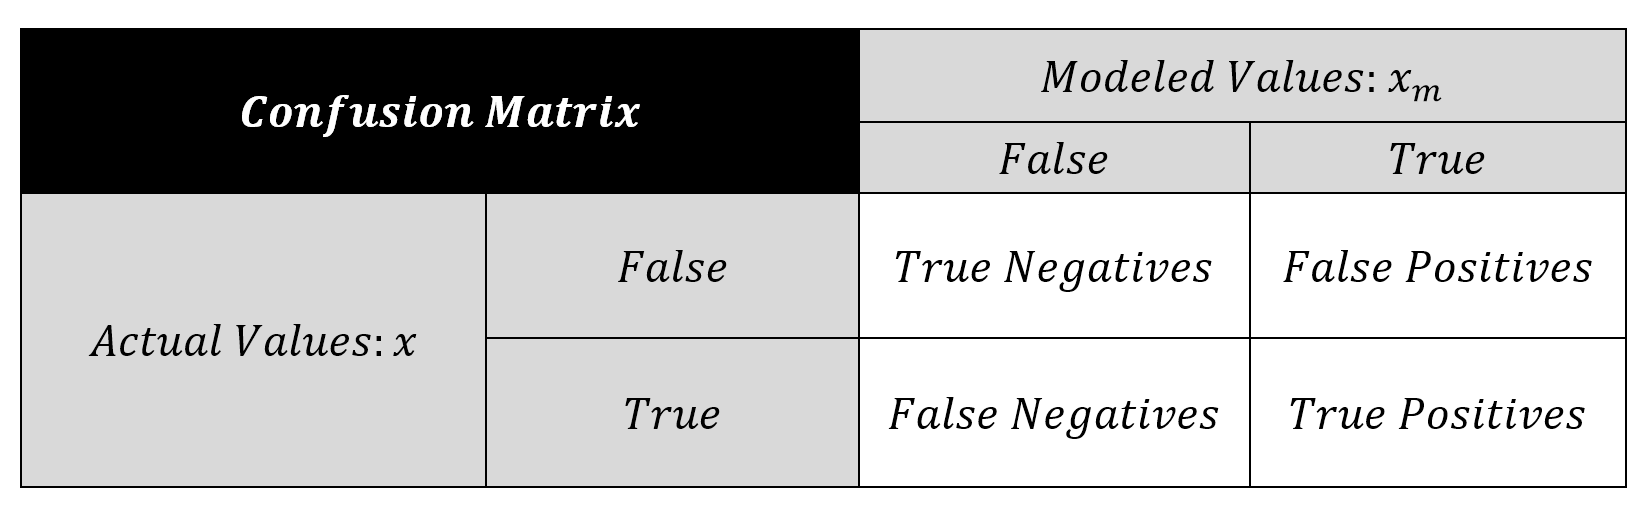

**From the accuracy score:**
- 71% is the number of times the model predicted the correct sentiment over all tweets in the dataset
- When the distribution of the classes is well-balanced, accuracy can give a good picture of how the model is performing


**From the confusion matrix:**
- In binary classification, the count of true negatives is (0,0), false negatives is (1,0), true positives is (1,1) and false positives is (0,1).
- From the results looks like the model predicted ~8k tweets correctly as positive and ~5k tweets correctly as negative

**From the Classification report:**
- From the classification report, precision is 68% for label 0 and 74% for label 1. This indicates the number of labels that were predicted correctly out of the total number of predictions for that class
- Recall: this indicates the number of predictions that were correct out of the true labels for that class


<a href="#top"> Back to Top </a>

In [32]:
#Predictions
preds = nb_model.predict(test_data['SentimentText'])

preds.shape

(299989,)

**Run the model to do some predictions on test dataset**


In [33]:
index = random.sample(range(preds.shape[0]), 20)
for text, sentiment in zip(test_data.SentimentText[index],
                           preds[index]):
    print (sentiment, '--', text, '\n')

0 -- @AH1001 Why?  And yeah I would like to see you before you go! It's been forevereverevereverandever! 

1 -- @ensredshirt I should've known that. Clearly, I am more of a Doctor Who fan than BTTF.  

0 --  wish i could have gone bowling tonight, ahh well Dr chace! &lt;3 

1 -- ... i can now offer cheaper on the furni that i need because of there cheaper values     I Love habtipsvalues.com #habbo 

1 -- @carambs according to http://superbianca.blogspot.com/ they sell them at anthem  

1 -- @jeanninefoley What a relief... it'll all be over soon  

1 -- @heduav i wrote u something on the msng  

1 -- @3aneeda Send me an email telling me about ur wedding customs in OMan  Im curious tra! 

1 -- @DinaUpdates boo. i &lt;3 those and would love one  

0 -- @Crucial_Xtreme went to the park with my son for an hour and im sad that im sad about not watching out for the telus tour  

0 -- @GayProudNSexy thats what i mean! but my cousin of all people. 16. is acting so superficial. he's a smart kid.

**Note: 0 refers to a negative sentiment and 1 refers to a positive sentiment**

In [34]:
import gensim.downloader as api

In [35]:
import numpy as np

def get_w2v_general(tweet, size, vectors, aggregation='mean'):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += vectors[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggregation == 'mean':
        if count != 0:
            vec /= count
        return vec
    elif aggregation == 'sum':
        return vec

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
import numpy as np

glove_twitter = api.load("glove-twitter-200")

train_vecs_glove_mean = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'mean') for z in x_train]))
validation_vecs_glove_mean = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'mean') for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_glove_mean, y_train)
print(clf.score(validation_vecs_glove_mean, y_validation))

0.7363736373637364
